In [1]:
import numpy as np 
import matplotlib.pyplot as plt

## On résoud l'équation $y'=-\lambda y$. On utilise un schéma d'Euler explicite et on compare la solution numérique avec la solution exacte

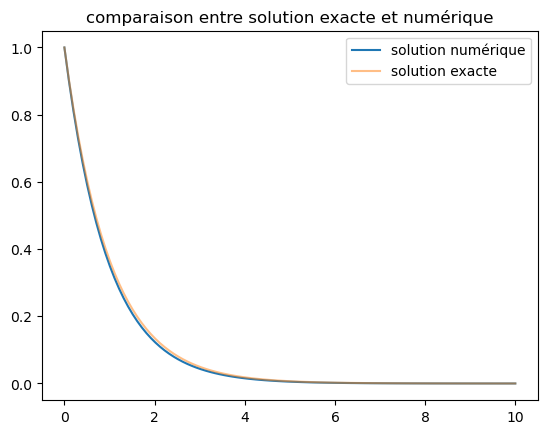

In [12]:
T=10
lmbd=1

def Euler_exp(dt):
    N=int(T/dt)
    
    t=np.linspace(0,T,N)
    y=np.exp(-lmbd*t)

    u0=np.ones(N)

    u=u0
    for n in range(N-1):
        u[n+1]=u[n]-lmbd*dt*u[n]
    
    erreur=(np.sum((u-y))**2)**0.5
        
    return u,erreur   

dt=0.1

t=np.linspace(0,T,int(T/dt))
u=Euler_exp(dt)[0]

plt.plot(t,u,label="solution numérique")
plt.plot(t,np.exp(-lmbd*t),label="solution exacte", alpha=0.5)
plt.title("comparaison entre solution exacte et numérique")
plt.legend()

## On trace maintenant l'erreur pour différents pas de temps $dt$

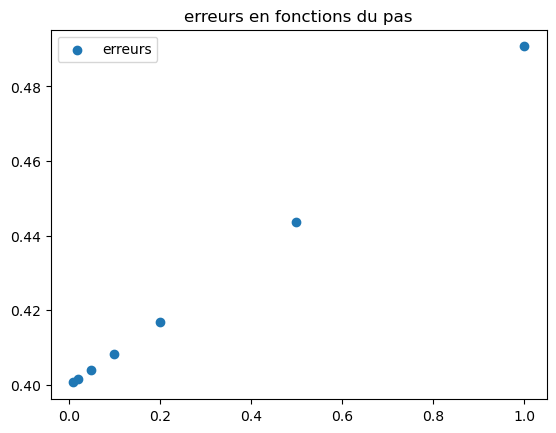

In [11]:
pas=[1,0.5,0.2,0.1,0.05,0.02,0.01]
erreurs=[]

for dt in pas:
    erreurs.append(Euler_exp(dt)[1])

plt.scatter(pas,erreurs,label="erreurs")  
plt.title("erreurs en fonctions du pas")
plt.legend()

## On résoud maintenant l'équation $u_t + v_1 u_x + v_2 u_y - \nu ( u_{xx} + u_{yy} ) = -\lambda u + f$ dans un domaine rectangulaire. On prend $f(t,s) = T_c \exp(-k d(s,s_c)^2)$   avec $d(s,s_c)^2 = (s_1 - s_{c,1})^2 + (s_2 - s_{c,2})^2$ 

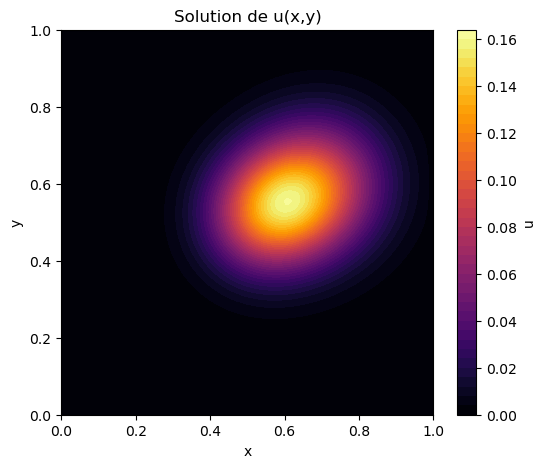

In [13]:
# --- Paramètres du problème ---
Lx, Ly = 1.0, 1.0         # dimensions du domaine
Nx, Ny = 100, 100         # nombre de points en x et y
dx, dy = Lx/(Nx-1), Ly/(Ny-1)
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

v1, v2 = 1.0, 0.5        # vitesses
nu = 0.01                 # diffusion
lam = 0.1                 # lambda
Tc = 1.0                  # amplitude de f
k = 50.0                  # largeur de la source
xc, yc = 0.5, 0.5         # centre de la source

# --- Fonction source ---
def f_source(X, Y):
    return Tc * np.exp(-k*((X - xc)**2 + (Y - yc)**2))

# --- Conditions initiales ---
u = np.zeros((Ny, Nx))

# --- Conditions aux limites (Dirichlet nulles) ---
def apply_bc(u):
    u[0,:] = 0
    u[-1,:] = 0
    u[:,0] = 0
    u[:,-1] = 0
    return u

# --- Pas de temps selon CFL diffusion et convection ---
dt_conv = min(dx/abs(v1), dy/abs(v2))
dt_diff = 0.25*min(dx**2, dy**2)/nu
dt = 0.5*min(dt_conv, dt_diff)  # sécurité
Nt = 200                        # nombre de pas de temps

# --- Boucle temporelle ---
for n in range(Nt):
    u_new = u.copy()
    
    # Différences finies centrées
    u_xx = (np.roll(u, -1, axis=1) - 2*u + np.roll(u, 1, axis=1))/dx**2
    u_yy = (np.roll(u, -1, axis=0) - 2*u + np.roll(u, 1, axis=0))/dy**2
    u_x = (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1))/(2*dx)
    u_y = (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0))/(2*dy)
    
    # Équation de convection-diffusion avec source et perte
    u_new += dt * (-v1*u_x - v2*u_y + nu*(u_xx + u_yy) - lam*u + f_source(X,Y))
    
    u = apply_bc(u_new)

# --- Affichage ---
plt.figure(figsize=(6,5))
plt.contourf(X, Y, u, 50, cmap='inferno')
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de u(x,y)')
plt.show()

### On revient à l'équation 1D $u_t + v_1 u_x - \nu  u_{xx} = -\lambda u + f$ avec condition initiale $u(0,x)=u_0(x)$ et conditions aux limites de type Dirichlet non homogène à gauche $u(t,0)=d$ et Neumann non homogène à droite $u_x(t,L)=g$.

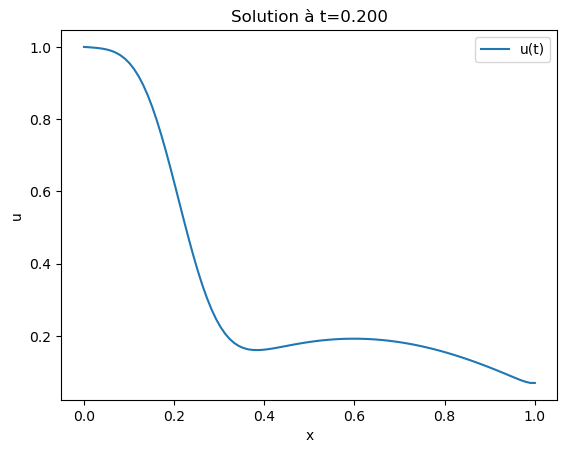

In [14]:
# --- Paramètres du problème ---
L = 1.0
Nx = 100
dx = L / (Nx-1)
x = np.linspace(0, L, Nx)

v1 = 1.0       # vitesse de convection
nu = 0.01      # diffusion
lam = 0.1      # perte
Nt = 200
dt = 0.001     # pas de temps

# --- Fonctions ---
def u0(x):
    return np.zeros_like(x)  # condition initiale

def d(t):
    return 1.0  # Dirichlet à gauche

def g(t):
    return 0.0  # Neumann à droite

def f(t,x):
    return np.sin(np.pi*x)  # exemple de source

# --- Initialisation ---
u = u0(x).copy()
u_new = u.copy()

# --- Boucle temporelle ---
for n in range(Nt):
    t = n*dt
    
    # --- Différences finies ---
    u_x = np.zeros_like(u)
    u_x[1:] = (u[1:] - u[:-1])/dx  # upwind simple pour convection
    u_x[0] = (u[1]-u[0])/dx        # au bord gauche

    u_xx = np.zeros_like(u)
    u_xx[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2])/dx**2
    u_xx[0] = (u[1]-2*u[0]+d(t))/dx**2      # bord gauche Dirichlet
    u_xx[-1] = (u[-2] - 2*u[-1] + u[-2] + dx*g(t))/dx**2  # Neumann droit

    # --- Mise à jour explicite ---
    u_new = u + dt*(-v1*u_x + nu*u_xx - lam*u + f(t,x))
    
    # --- Conditions aux limites ---
    u_new[0] = d(t)
    u_new[-1] = u_new[-2] + dx*g(t)  # Neumann

    u = u_new.copy()

# --- Affichage ---
plt.plot(x, u, label='u(t)')
plt.xlabel('x')
plt.ylabel('u')
plt.title(f'Solution à t={Nt*dt:.3f}')
plt.legend()
plt.show()